In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we can estimate: how many visits could we have for every field, if we evenly split a typical total number of visits over a very large sky footprint? 

So first: estimate the total number of visits available. 

In [2]:
# Total approximate number of visits in opsim:
totalNvis = 2400000
# Let's say we can play with 93% of these visits
totalNvis *= 0.93
print("The number of visits available is %d (%.2fM)" % (totalNvis, totalNvis/1000000))

The number of visits available is 2232000 (2.23M)


Now we'll count the number of fields we want to include in this 'big sky' footprint, using the opsim tessellation. This is equivalent to estimating the number of pointings required to cover the footprint.

In [3]:
# Read the field list.
fields = pd.read_csv('field_list.csv')
# what does the field list look like?
fields[0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb
0,1,3.5,0.000000,-90.000000,-57.068082,-27.128251,-89.931210,-66.561358
1,2,3.5,180.000000,-87.568555,-57.663825,-24.756541,-96.024547,-66.442665
2,3,3.5,324.000429,-87.568550,-54.980423,-28.712449,-85.262622,-65.058907
3,4,3.5,35.999571,-87.568550,-58.164147,-29.359810,-84.695237,-67.907706
4,5,3.5,252.001105,-87.568547,-54.748581,-25.862125,-91.659618,-64.238559


In [4]:
# Select fields with declination between -90 and 32 -- our "big sky" footprint
bigsky = fields.query('(dec >= -90) and (dec <= 32)') 

/Users/edward/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


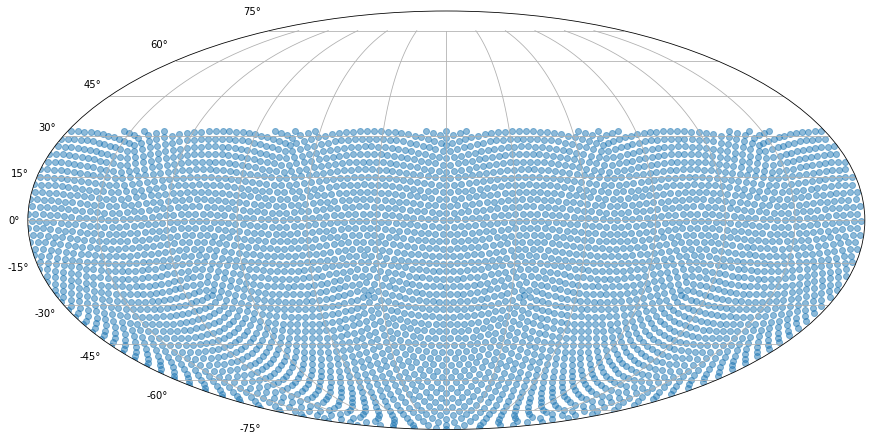

In [6]:
# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    ra = np.array(ra)
    dec = np.array(dec)
    ra[ra>180] -= 360
    return (-np.radians(ra), np.radians(dec))

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111, projection="mollweide")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
x, y = radec2project(bigsky.ra, bigsky.dec)
ax.scatter(x, y, alpha=0.5)
plt.grid(True)

In [7]:
# How many fields are included in this "big sky" version of the survey?
nfields = len(bigsky)
print("The number of fields in the footprint is %d" % (nfields))

The number of fields in the footprint is 4066


So how many visits could we potentially have per field, if we split them evenly among fields?

In [8]:
# Exact number of visits per field
visPerField = totalNvis / nfields
# Round the number of visits per field to an integer
visPerField = int(round(visPerField))
# And recalculate what this means for the totalNvis -- if the total # changed too much, maybe round down
propTotal = visPerField * nfields
print("This corresponds to %d visits per field" % (visPerField, ))
print("This implies a total number of visits required of %d (compared to original estimate of %d): %.2f%s change"
     % (propTotal, totalNvis, float(propTotal - totalNvis) / totalNvis * 100.0, "%"))

This corresponds to 549 visits per field
This implies a total number of visits required of 2232234 (compared to original estimate of 2232000): 0.01% change


Let's add some estimate on the coadded depths you could achieve.

This requires assuming a dark sky, zenith, typical single visit depth and then scaling by the number of visits in each filter. 

In [9]:
# Current expected performance
single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}

In [10]:
# How should we divide the visits? (per field) 
fractionsPerFilter = {'u': 0.12, 'g': 0.17, 'r': 0.23, 'i': 0.23, 'z': 0.25, 'z': 0.25}
fracSum = 0
for f, v in fractionsPerFilter.items():
    fracSum += v
    print('Fraction in %s: %.3f' % (f, v))
print("Total: %.3f" % (fracSum))

Fraction in u: 0.120
Fraction in g: 0.170
Fraction in r: 0.230
Fraction in i: 0.230
Fraction in z: 0.250
Total: 1.000


In [11]:
# Make actual numbers per filter .. jiggle as necessary. (note that you could set these by hand instead)
visPerFilter = {}
fieldTotal = 0
for f in fractionsPerFilter:
    visPerFilter[f] = int(round(fractionsPerFilter[f] * visPerField))
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))

Visits in u: 66
Visits in g: 93
Visits in r: 126
Visits in i: 126
Visits in z: 137
Total per field: 548 (compared to potential 549 per field previously calculated)


In [12]:
# Jiggle by hand .. 
visPerFilter['g'] += 1
fieldTotal = 0
for f in visPerFilter:
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))

Visits in u: 66
Visits in g: 94
Visits in r: 126
Visits in i: 126
Visits in z: 137
Total per field: 549 (compared to potential 549 per field previously calculated)


So calculate the scaled coadded depth per filter, per field. Note that this assumes all observations are taken under the same "dark-sky, zenith" conditions.

In [13]:
coadd_m5 = {}
for f in visPerFilter:
    coadd_m5[f] = single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f]))
    print("Coadded depth in %s: %.2f" % (f, coadd_m5[f]))

Coadded depth in u: 26.25
Coadded depth in g: 27.38
Coadded depth in r: 27.05
Coadded depth in i: 26.60
Coadded depth in z: 26.05


Given "realistic" opsim conditions, we would expect some typical offsets from these dark-sky, zenith coadded depths. 
Using the WFD region from kraken\_2026 we can calculate these expected offsets:

In [14]:
# Using estimates from kraken_2026:
kraken_single_m5 = {'u': 23.78, 'g': 24.81, 'r': 24.35, 'i': 23.92, 'z': 23.34, 'y': 22.45}
visPerFilter = {'u': 64, 'g': 90, 'r': 206, 'i': 204, 'z': 186, 'y': 188}
opsimCoaddM5 = {'u': 25.65, 'g': 27.15, 'r': 27.20, 'i': 26.62, 'z': 25.72, 'y': 24.91}
kraken_coadd_m5 = {}
offset = {}
for f in visPerFilter:
    kraken_coadd_m5[f] = kraken_single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f]))
    offset[f] = kraken_coadd_m5[f] - opsimCoaddM5[f]
    print("Coadded depth in %s: %.2f - correction is %.2f" % (f, kraken_coadd_m5[f], offset[f]))

Coadded depth in u: 26.04 - correction is 0.39
Coadded depth in g: 27.25 - correction is 0.10
Coadded depth in r: 27.24 - correction is 0.04
Coadded depth in i: 26.81 - correction is 0.19
Coadded depth in z: 26.18 - correction is 0.46
Coadded depth in y: 25.29 - correction is 0.38


In [15]:
saved_offsets = {'u': 0.39, 'g': 0.10, 'r': 0.04, 'i': 0.19, 'z': 0.46, 'y': 0.38}

In [16]:
#calculate the arc length
def arc(RA1, RA2, DEC1, DEC2):
    RA1 = RA1*np.pi/180
    RA2 = RA2*np.pi/180
    DEC1 = DEC1*np.pi/180
    DEC2 = DEC2*np.pi/180
    dDEC = DEC1-DEC2
    dRA = RA1 - RA2
    c = (np.sin((dDEC/2.))**2 + np.cos(DEC1)*np.cos(DEC2)*np.sin(dRA/2.)**2)**0.5
    ARC = 2*np.arcsin(c)
    return ARC*180./np.pi

In [17]:
#define the regions
SCP = bigsky[bigsky.dec < -60] #South Celestial Pole
GP = bigsky[abs(bigsky.gb) <= 15] #Galactic Plane 
EP = bigsky[abs(bigsky.eb) <= 10] #Ecliptic Plane
EG = bigsky[abs(bigsky.gb) > 20]  #extra-Galactic
ra_LMC =  80.893750 
dec_LMC = -69.756111
ra_SMC = 13.186667
dec_SMC = -72.828611
LMC = fields[arc(fields.ra, ra_LMC, fields.dec, dec_LMC) < 10] #LMC region
SMC = fields[arc(fields.ra, ra_SMC, fields.dec, dec_SMC) < 5] #SMC region

In [29]:
#Plot them
def plot(regions):
    fig = plt.figure(figsize=(15, 8))
    ax = plt.subplot(111, projection="mollweide")
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    for i in regions:
        x, y = radec2project(i.ra, i.dec)
        ax.scatter(x, y, alpha=0.3)
    plt.grid(True) 

/Users/edward/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


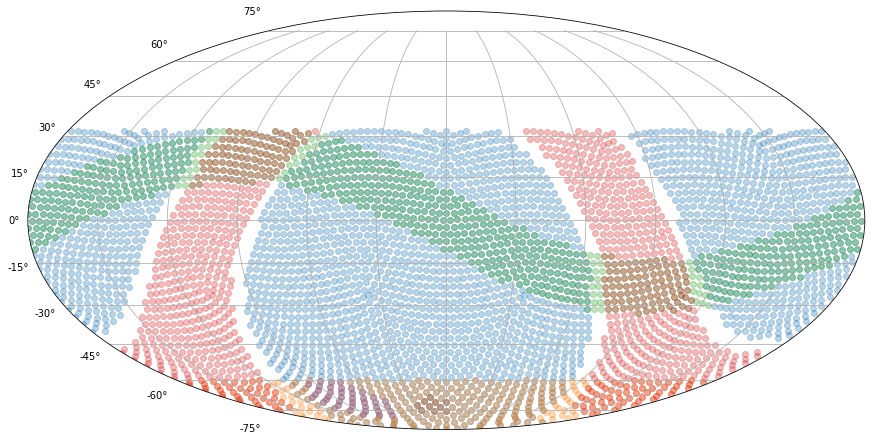

In [30]:
regions = [EG, SCP, EP, GP, LMC, SMC]
plot(regions)   

In [31]:
#count the number of fields
nfields_EP = len(EP)
print("The number of fields in the footprint is %d" % (nfields))

The number of fields in the footprint is 4066


In [32]:
#how many more TNOs we can get from "bigsky"?
#the "extra_area" is the extra survey area that useful for founding solar system objects
#the surface density of hot population TNOs is ~ 2/sq.deg.
extra_area_mask = np.logical_and(bigsky.dec > 0, bigsky.eb > 10)
extra_area_eff_mask = np.logical_and(bigsky.eb < 30, extra_area_mask)
extra_area_eff_mask &= abs(bigsky.gb) > 15
extra_area = bigsky[extra_area_eff_mask]                 

/Users/edward/anaconda2/envs/py3/lib/python3.6/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


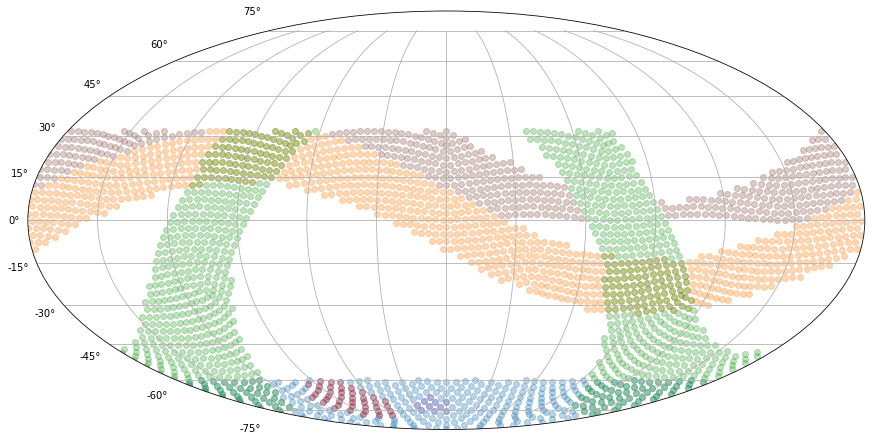

In [33]:
regions = [SCP, EP, GP, LMC, SMC, extra_area]
plot(regions)   

In [23]:
print("extra survey area compare to the baseline: {}".format(len(extra_area)))
print("extra survey area compare to the baseline: {} sq.deg.".format(len(extra_area)*3.5))
print("extra 'hot population TNOs' compare to the baseline: {} ".format(int(round(len(extra_area)*3.5*2))))

extra survey area compare to the baseline: 432
extra survey area compare to the baseline: 1512.0 sq.deg.
extra 'hot population TNOs' compare to the baseline: 3024 


In [24]:
#how many more Sedna-like (ETNOs) we can get from "bigsky"?
#the surface density of Sedna-like is ~ 0.006/sq.deg.
print("extra 'sedna-like' compare to the baseline: {} ".format(int(round(len(extra_area)*3.5*0.006))))

extra 'sedna-like' compare to the baseline: 9 
